<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 4 Fraud Analysis

# Problem Statement

Credit card fraud is a growing problem in our society as more and more transactions are conducted online and digitally. The annual cost of credit card fraud is estimated to be in the billions of dollars, and it not only results in financial losses for individuals, but also undermines trust in the banking system. With the shift towards cashless transactions, it is more important than ever to improve fraud detection to protect consumers from identity theft, unauthorized transactions, and financial losses. In this project, we aim to develop a classification model using simulated credit card fraud data to detect fraudulent transactions and reduce these losses. By effectively detecting and preventing credit card fraud, we can help build a more secure and trustworthy financial system for all Americans.


To do this, our project will complete the following steps:
1) We clean the data, conduct exploratory data analysis, preprocess and engineer features for our classification model.
2) After testing several modeling strategies, we evaluate our model assumptions and choose an approach that will lead to the best performance in terms of key classification metrics.
3) We present our findings, highlighting our model's performance in predicting fraud and the features that will likely impact fraud detection most. 

##### Imports for model

In [11]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib
import seaborn as sns

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

##### Read in the data

In [12]:
df = pd.read_csv('data/fraud_records.csv')

## Data Cleaning

##### Data cleaning will consist of the following:
    1) Visually inspecting the data and converting column names
    2) Checking and correcting missing data
    3) Converting data to correct data types

In [13]:
df.head()

,ssn,cc_num,first,last,gender,street,city,state,zip,lat,...,trans_num,trans_date,trans_time,unix_time,category,amt,is_fraud,merchant,merch_lat,merch_long
0,697-93-1877,4514627048281480,Lisa,Hernandez,F,809 Burns Creek,Hunter,NY,12442,42.2333,...,b40239817d29f8c5894c6d1f4dbf570c,2021-05-17,01:48:07,1621230487,shopping_net,9.85,1,fraud_Gleason-Macejkovic,41.546458,-74.233147
1,697-93-1877,4514627048281480,Lisa,Hernandez,F,809 Burns Creek,Hunter,NY,12442,42.2333,...,25ab96365ed24c301c72501a3b44a4e5,2021-05-17,00:29:09,1621225749,shopping_net,339.71,1,fraud_Mohr-Bayer,42.939539,-74.797924
2,697-93-1877,4514627048281480,Lisa,Hernandez,F,809 Burns Creek,Hunter,NY,12442,42.2333,...,40f714fb0545f2749b0d2ee7a1b3fc9c,2021-05-17,00:07:04,1621224424,misc_net,828.05,1,"fraud_Hayes, Marquardt and Dibbert",42.674467,-74.741182
3,697-93-1877,4514627048281480,Lisa,Hernandez,F,809 Burns Creek,Hunter,NY,12442,42.2333,...,d15c033672074d31913e11e977d0bd3d,2021-05-17,00:39:00,1621226340,misc_net,776.30,1,"fraud_Tillman, Fritsch and Schmitt",42.855690,-73.934155
4,697-93-1877,4514627048281480,Lisa,Hernandez,F,809 Burns Creek,Hunter,NY,12442,42.2333,...,54a97de986d96d2fe27975f5a418a98d,2021-05-17,03:27:08,1621236428,grocery_pos,1049.03,1,fraud_Stracke-Lemke,43.125025,-73.805859


In [14]:
df.columns

Index(['ssn', 'cc_num', 'first', 'last', 'gender', 'street', 'city', 'state',
       'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'acct_num', 'profile',
       'trans_num', 'trans_date', 'trans_time', 'unix_time', 'category', 'amt',
       'is_fraud', 'merchant', 'merch_lat', 'merch_long'],
      dtype='object')

In [16]:
len(pd.unique(df['cc_num']))

1496

#### Check for missing values

In [17]:
# check train nulls
df.isnull().sum().sort_values(ascending = False).loc[lambda x: x> 0]

Series([], dtype: int64)

In [18]:
df.nunique()

ssn              1496
cc_num           1496
first             423
last              606
gender              2
street           1496
city             1000
state              51
zip              1403
lat              1396
long             1400
city_pop         1077
job               571
dob              1448
acct_num         1496
profile            12
trans_num     2600454
trans_date        730
trans_time      86400
unix_time     2497514
category           14
amt             71066
is_fraud            2
merchant          693
merch_lat     2405096
merch_long    2514269
dtype: int64

#### Check data types

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600454 entries, 0 to 2600453
Data columns (total 26 columns):
 #   Column      Dtype  
---  ------      -----  
 0   ssn         object 
 1   cc_num      int64  
 2   first       object 
 3   last        object 
 4   gender      object 
 5   street      object 
 6   city        object 
 7   state       object 
 8   zip         int64  
 9   lat         float64
 10  long        float64
 11  city_pop    int64  
 12  job         object 
 13  dob         object 
 14  acct_num    int64  
 15  profile     object 
 16  trans_num   object 
 17  trans_date  object 
 18  trans_time  object 
 19  unix_time   int64  
 20  category    object 
 21  amt         float64
 22  is_fraud    int64  
 23  merchant    object 
 24  merch_lat   float64
 25  merch_long  float64
dtypes: float64(5), int64(6), object(15)
memory usage: 515.8+ MB


Our data types are the correct type at this point in our analysis. After conducting EDA, we may choose to tranform the data and will need to consider changing the data types of categorical variables.

## Exploratory Data Analysis

#### Our EDA section covers
    1) Examining summary statistics
    2) Outlier analysis
    3) Examining distributions to inform our modeling approach

In [20]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
cc_num,2600454.0,3.419284e+17,1.191885e+18,6.040192e+10,1.800021e+14,3.520510e+15,4.599997e+15,4.986227e+18
zip,2600454.0,5.158671e+04,2.985793e+04,1.060000e+03,2.761700e+04,4.905800e+04,7.824900e+04,9.980100e+04
lat,2600454.0,3.793976e+01,5.332446e+00,1.955060e+01,3.408120e+01,3.892020e+01,4.143350e+01,6.491090e+01
long,2600454.0,-9.251659e+01,1.691037e+01,-1.581781e+02,-9.864330e+01,-8.779140e+01,-8.002880e+01,-6.841210e+01
city_pop,2600454.0,3.092740e+05,5.834907e+05,2.620000e+02,1.751200e+04,6.526100e+04,2.509750e+05,2.906700e+06
acct_num,2600454.0,5.130132e+11,2.894180e+11,1.896309e+09,2.687536e+11,5.127099e+11,7.830663e+11,9.993899e+11
unix_time,2600454.0,1.642717e+09,1.821444e+07,1.609477e+09,1.627067e+09,1.641116e+09,1.658630e+09,1.672549e+09
amt,2600454.0,7.085574e+01,1.715623e+02,1.000000e+00,9.060000e+00,4.428000e+01,8.173000e+01,2.828574e+04
is_fraud,2600454.0,5.501347e-03,7.396678e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
merch_lat,2600454.0,3.793978e+01,5.363163e+00,1.855151e+01,3.424879e+01,3.886738e+01,4.142172e+01,6.591033e+01


In [21]:
df.is_fraud.value_counts()

0    2586148
1      14306
Name: is_fraud, dtype: int64

In [22]:
df.is_fraud.value_counts(normalize=True).mul(100).round(2)

0    99.45
1     0.55
Name: is_fraud, dtype: float64

#### We note highly imbalanced classes, which is a common challange of fraud detection problems.

<Figure size 1000x800 with 0 Axes>

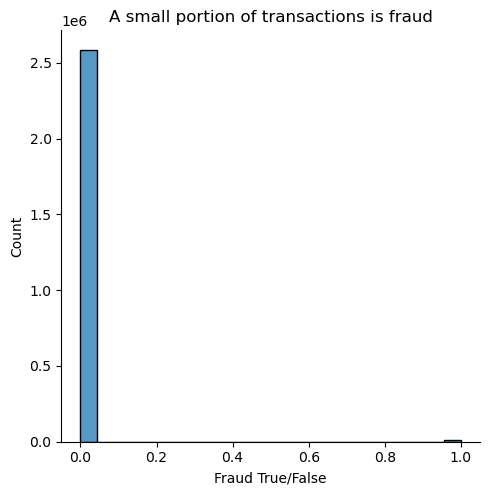

In [47]:
plt.figure(figsize=(10,8));
sns.displot(df['is_fraud']).set(title = 'A small portion of transactions is fraud', 
                                                   xlabel='Fraud True/False', 
                                                   ylabel='Count');

### Examine box plots

In [65]:
num_cols = list(df.select_dtypes([np.int64,np.float64]).columns)

In [60]:
cols_to_remove = ['cc_num','lat','long','acct_num','merch_lat','merch_long']
for item in cols_to_remove:
    num_cols.remove(item)
num_cols

['zip', 'city_pop', 'unix_time', 'amt', 'is_fraud']

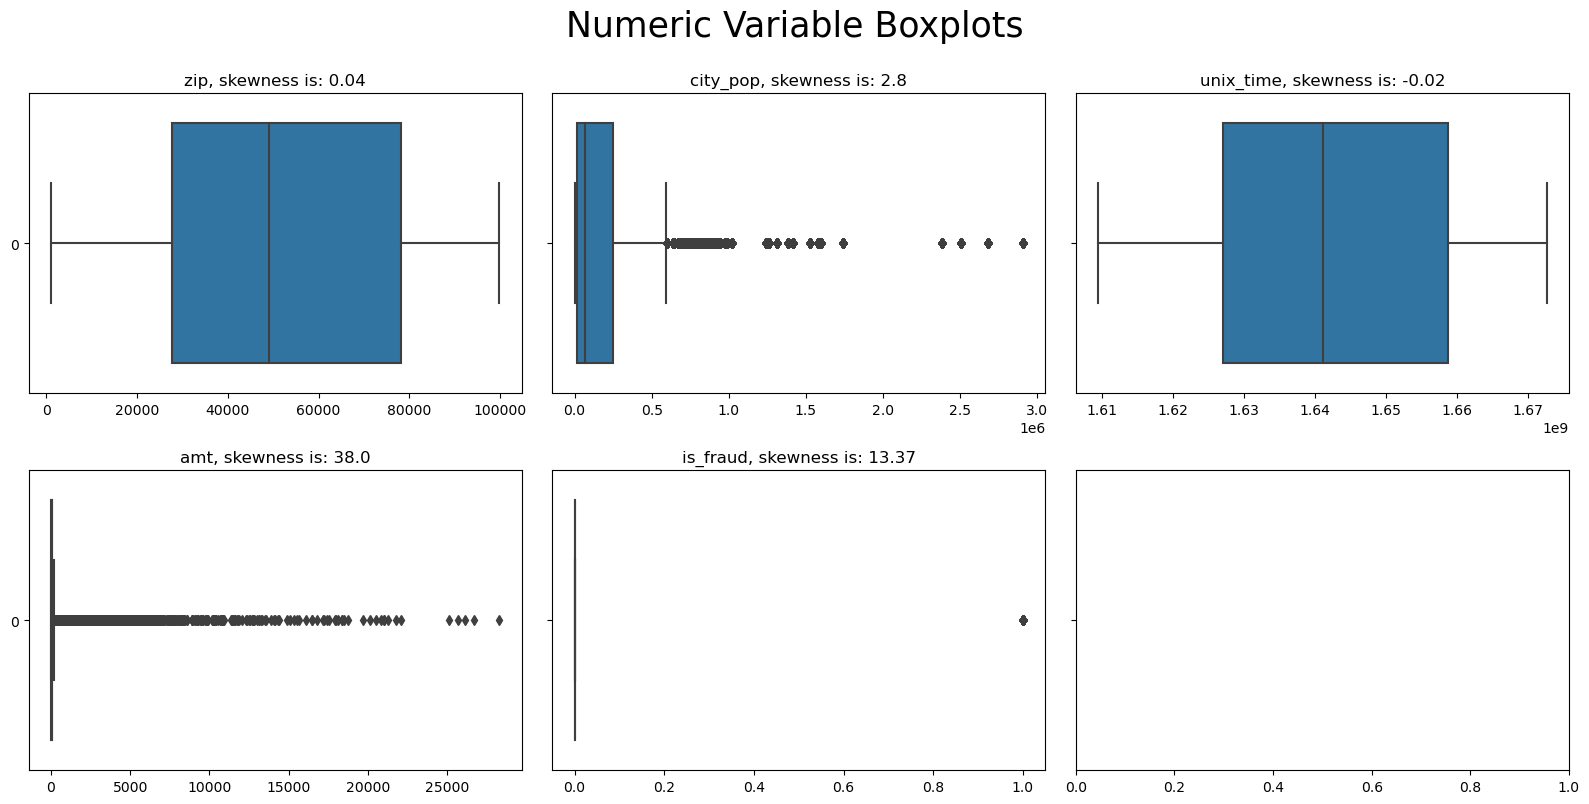

In [64]:
def get_boxplots(dataset, columns_list, rows, cols, suptitle):
    fig, axs = plt.subplots(2, 3, sharey=True, figsize=(16,8))
    fig.suptitle(suptitle,y=1, size=25)
    axs = axs.flatten()
    for i, data in enumerate(columns_list):
        sns.boxplot(data=dataset[data], orient='h', ax=axs[i])
        axs[i].set_title(data + ', skewness is: '+str(round(dataset[data].skew(axis = 0, skipna = True),2)))
        
get_boxplots(dataset=df, columns_list=num_cols, rows=4, cols=3, suptitle='Numeric Variable Boxplots')
plt.tight_layout()

### Examine correlationss

In [29]:
df.corr()['is_fraud'].sort_values()

unix_time    -0.009710
acct_num     -0.002885
lat          -0.002774
merch_lat    -0.002620
long         -0.000313
merch_long   -0.000311
zip           0.000729
city_pop      0.001152
cc_num        0.002369
amt           0.200836
is_fraud      1.000000
Name: is_fraud, dtype: float64

<AxesSubplot:>

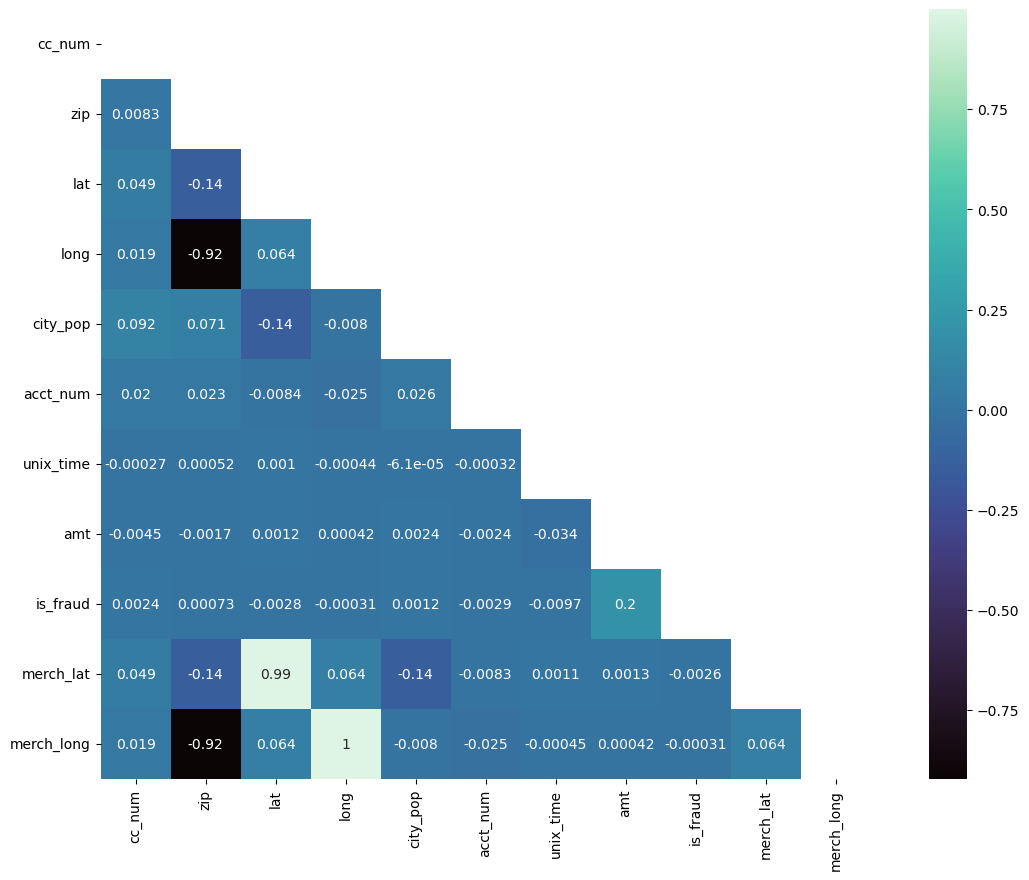

In [30]:
# Establish size of figure.
plt.figure(figsize=(15,10))

# Get correlation of variables.
corr = df.corr()

# Set up mask to be "True" in the upper triangle.
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Plot our correlation heatmap, while masking the upper triangle to be white.
sns.heatmap(corr, mask = mask, 
            square = True, annot = True,
           cmap = 'mako')

### Discuss heat map

As expected, the heat map has little value in terms of informing our analysis.

In general it's a change in the normal 'pattern' of the customer which would likely be correlated with fraud vs. the value itself.

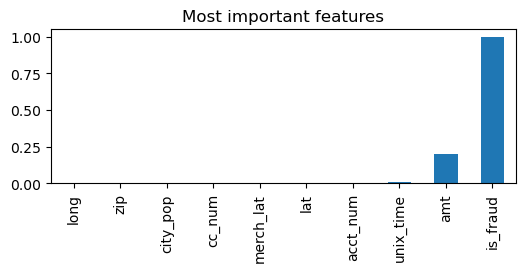

In [68]:
plt.figure(figsize=(6,2))
d = df.corr()['is_fraud'][:-1].abs().sort_values().plot(kind='bar',
                                                              title='Most important features')
plt.show()

### Feature distribution

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def distribution_plots(df, columns):
    n = len(columns)
    if n>11:
        print("Error: Number of columns exceeds limit of 9 columns")
        return
    rows, cols = np.int(np.ceil(n/3)), 3
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(13,8))
    for i, column in enumerate(columns):
        ax = axes.flat[i]
        ax.hist(df[column], bins=60, linewidth=0.5, edgecolor="white")
        ax.set_title(f"{column} distribution")
    plt.tight_layout()
    plt.show()


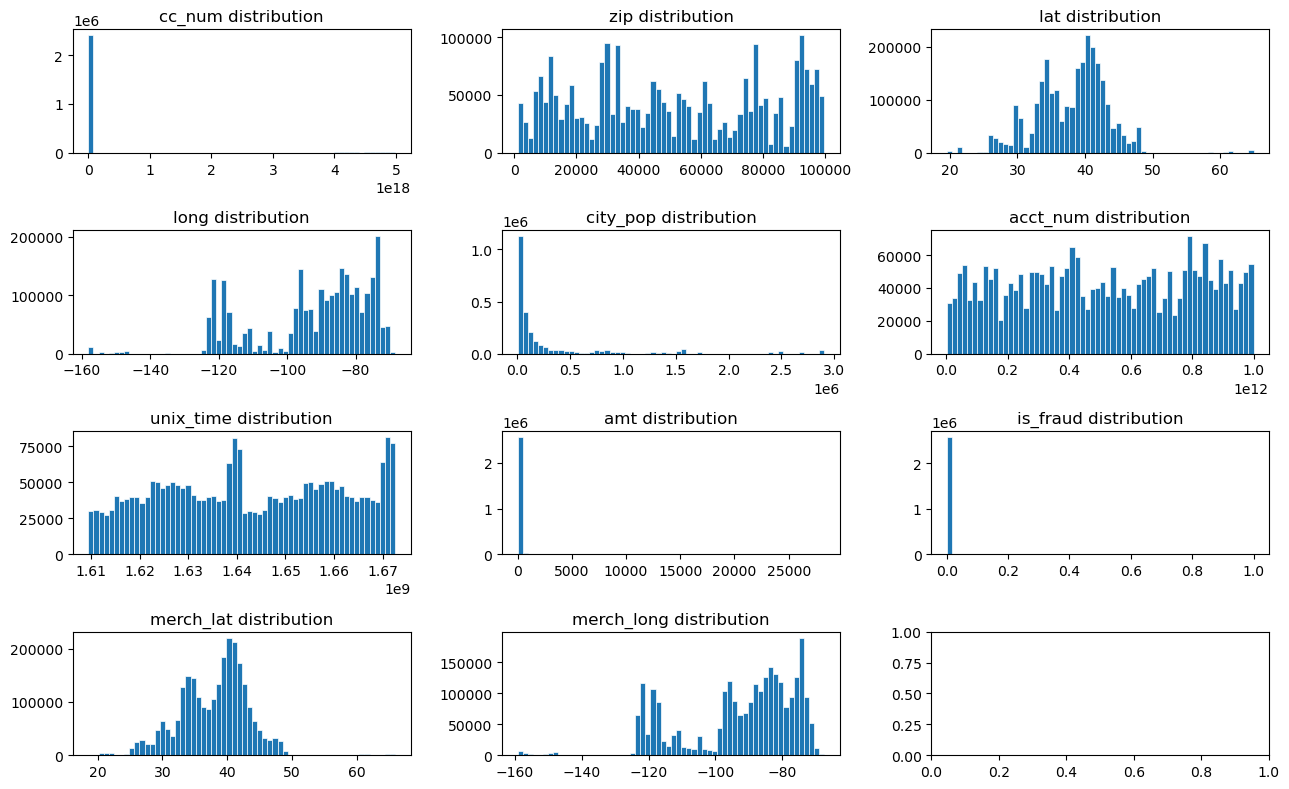

In [33]:
columns = list(df.columns)
distribution_plots(df, num_cols)

### Outlier analysis - not needed

##### We did not do outlier analysis on this data set because it was generated using a simmulation tool. Since we specified the distributions in the simmulation tool, it's unreasonable to expect that we would have true outliers in this dataset. 

## Examine relationships of different features

In [ ]:
def count_fraud_values(df, column):
    fraud_df = df[df['is_fraud'] == 1]
    value_counts = fraud_df[column].value_counts()
    return value_counts

In [94]:
count_fraud_values(df, 'gender')

M    7315
F    6991
Name: gender, dtype: int64

In [103]:
df.groupby(['is_fraud','gender']).count()['ssn']

is_fraud  gender
0         F         1315303
          M         1270845
1         F            6991
          M            7315
Name: ssn, dtype: int64

In [111]:
df.groupby(by=['is_fraud']).mean()['amt']

is_fraud
0     68.293049
1    534.123448
Name: amt, dtype: float64

In [113]:
def fraud_distribution_v3(df, column):
    """
    Input dataframe and column of interest. The function returns distribution information 
    the column of interest.
    """
    df_col = df[[column,'trans_num']].groupby([column]).agg({'trans_num':'count'}).reset_index()
    df_col.columns = [column, column+'_count']

    df_fraud_col = df[[column, 'trans_num',
                       'is_fraud']].groupby([column, 
                                             'is_fraud']).agg({'trans_num':'count'}).reset_index()
    df_fraud_col.columns = [column, 'is_fraud', 'transaction_count']
    df_fraud_col = df_fraud_col.merge(df_col, how='inner', on=column)
    df_fraud_col['transaction_percent'] = round(\
                                        (df_fraud_col['transaction_count']/df_fraud_col[column+'_count'])*100, 2)
    df_fraud_col = df_fraud_col.reindex(columns=[column,'transaction_count', column+'_count', 'transaction_percent', 'is_fraud'])
    return df_fraud_col

In [40]:
fraud_distribution_v3(df, 'gender')

,gender,transaction_count,gender_count,transaction_percent,is_fraud
0,F,1315303,1322294,99.47,0
1,F,6991,1322294,0.53,1
2,M,1270845,1278160,99.43,0
3,M,7315,1278160,0.57,1


In [115]:
df.groupby(['is_fraud','gender']).count()['ssn']

is_fraud  gender
0         F         1315303
          M         1270845
1         F            6991
          M            7315
Name: ssn, dtype: int64

In [118]:
f'Real-to-fraud ration in males: {round((1270845 / 7315),1)}'

'Real-to-fraud ration in males: 173.7'

In [119]:
f'Real-to-fraud ration in females: {round ((1315303 / 6991),1)}'

'Real-to-fraud ration in females: 188.1'

We observe approximately the same number of fraud transaction for both genders. However, the proportion of male transactions that are  fraudulent is higher than females.

In [42]:
df_fraud_state = fraud_distribution_v3(df, 'state')
df_fraud_state[df_fraud_state['is_fraud'] == 1].sort_values(by='transaction_percent',
                                                            ascending=False).head(10)

,state,transaction_count,state_count,transaction_percent,is_fraud
101,WY,25,1480,1.69,1
65,NM,78,5900,1.32,1
17,DE,38,5131,0.74,1
97,WI,352,49778,0.71,1
3,AL,198,28582,0.69,1
75,OR,162,23440,0.69,1
39,MA,297,43935,0.68,1
89,UT,173,25611,0.68,1
41,MD,172,25627,0.67,1
91,VA,284,43889,0.65,1


Here we observe that some states have a higher percentage of fraudulent transactions (e.g. WY specifically). 

In [43]:
df_fraud_category = fraud_distribution_v3(df, 'category')
df_fraud_category[df_fraud_category['is_fraud'] == 1].sort_values(by='transaction_percent',
                                                            ascending=False).head(10)

,category,transaction_count,category_count,transaction_percent,is_fraud
23,shopping_net,3299,191216,1.73,1
17,misc_net,1871,118834,1.57,1
9,grocery_pos,3357,243242,1.38,1
25,shopping_pos,1645,257109,0.64,1
5,gas_transport,1158,225837,0.51,1
27,travel,242,82890,0.29,1
19,misc_pos,452,170388,0.27,1
1,entertainment,412,189692,0.22,1
7,grocery_net,231,109691,0.21,1
21,personal_care,355,183951,0.19,1


Unsurprisingly, there's a slightly higher percentage of fraudulent transactions in the shopping_net category. 

In [44]:
df_fraud_merchant = fraud_distribution_v3(df, 'merchant')
df_fraud_merchant[df_fraud_merchant['is_fraud'] == 1].sort_values(by='transaction_percent',
                                                            ascending=False).head(10)

,merchant,transaction_count,merchant_count,transaction_percent,is_fraud
471,"fraud_Hayes, Marquardt and Dibbert",58,2394,2.42,1
387,fraud_Gleason-Macejkovic,87,3867,2.25,1
345,"fraud_Ferry, Lynch and Kautzer",54,2431,2.22,1
543,fraud_Huel-Langworth,51,2357,2.16,1
145,fraud_Boyer-Reichert,82,3849,2.13,1
785,"fraud_Little, Gutmann and Lynch",84,3957,2.12,1
1247,"fraud_Tillman, Fritsch and Schmitt",50,2378,2.10,1
513,fraud_Hills-Witting,83,3999,2.08,1
1121,fraud_Schmitt Ltd,49,2367,2.07,1
73,fraud_Bednar Group,49,2402,2.04,1


There are no particular merchants whom we could point to as being mainly fraudulent. 

#### In conclusion, the EDA reveals that there are few immedaitely easy-to-spot patterns about what makes a transaction fraudulent. There are a few relationships, however:
- There are few fraudulent transactions; <1% of all transactions are fraudulent 
- Fradulent transactions tend to be slightly higher % male vs. female
- Fradulent transactiosn tend to be higher dollar amounts ~6x greater than non-fraudlent transactions on average 
- Fradulent transactions do tend to be slightly higher in certain geographies (observable at a state-level)

However, these relationships are tenuous, and we will have to feature engineer and use sophisticated models to accurately identify fraudelent transactions. 